# 课时57 猫狗数据实例_数据读取

In [81]:
import pandas as pd
import numpy as np
import seaborn as sb
sb.set_style('darkgrid')
# pathlib相比os.path更好用
import pathlib
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import os
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.0.0


# 1. 获取数据并做处理

In [82]:
# 获取指定路径下所有数据的路径地址
data_path = '../input/cat-and-dog/training_set/training_set'
# '/*/*.jpg'代表获取所有文件夹下的所有jpg文件
train_images_path = glob.glob(pathname=data_path+'/*/*.jpg')
len(train_images_path)

2000

In [68]:
# 获取指定路径下所有数据的标签
train_images_label = [int(path.split('training_set/training_set/')[1].split('/')[0]=='cats') for path in train_images_path]
len(train_images_label)

In [69]:
# 定义加载和处理指定地址的图片的函数
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path) # 读取指定路径的图片文件
    # 需要注意的是tf.image.decode_jpeg默认解码后的图片channel=0, 这里的图片是彩色图片，需要设置channel=3
    image = tf.image.decode_jpeg(image, channels=3) # 解码读取到的原始图片文件
    # 对于数据集中的图片，每个图片的长宽大小并非是固定的，为了能够较好的传入到模型中，因此需要将图片的大小固定
    image = tf.image.resize(image, size=[320, 320])
    
    # 对图片进行数据增强
    # 对图片进行随机裁剪
    image = tf.image.random_crop(value=image, size=[256, 256, 3])
    # 对图片进行随机左右翻转
    image = tf.image.random_flip_left_right(image=image)
    # 对图片进行随机上下翻转
    image = tf.image.random_flip_up_down(image=image)
    # 对图片进行随机亮度改变
    image = tf.image.random_brightness(image=image, max_delta=0.5)
    # 对图片进行随机对比度改变
    image = tf.image.random_contrast(image=image, lower=0, upper=1)
    # 对图片进行色相变换
    image = tf.image.adjust_hue(image, 0.3)
    
    # 将图片的数据类型从uint8转换为float32类型
    image = tf.cast(image, tf.float32)
    # 图片数据归一化
    image = image / 255
    # 需要注意一点的是有一个函数：tf.image.cover_image_dtype()对于非float32类型的图片在转换的时候回顺便做图片的归一化
    # 但是如果图片本身就是float32类型的数据，则该函数不过做图片的归一化
    
    # 对于图片的标签，由于所有的样本标签在一个列表中，所以需要将标签列表转换为二维数据
    label = tf.reshape(label, [1])
    return image, label

In [70]:
# 创建数据Dataset
train_images_dataset = tf.data.Dataset.from_tensor_slices((train_images_path, train_images_label))
# tf.data.experimental.AUTOTUNE根据可用的CPU数目动态设置并行调用的数量对数据进行处理
# 使用AUTOTUNE自动调节数据处理管道的参数
AUTOTUNE = tf.data.experimental.AUTOTUNE 
# 应用load_and_preprocess_image()函数对于train_images_dataset进行图片和标签处理
train_images_dataset = train_images_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
train_images_dataset

<ParallelMapDataset shapes: ((256, 256, 3), (1,)), types: (tf.float32, tf.int32)>

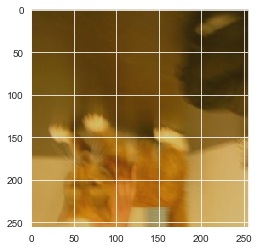

In [80]:
# for img, label in train_images_dataset.take(1):
#     plt.imshow(img)

In [19]:
# 对于获取到的Dataset数据集进行乱序和batch划分
BATCH_SIZE = 64
train_count = len(train_images_path)
train_images_dataset = train_images_dataset.shuffle(buffer_size=train_count).batch(batch_size=BATCH_SIZE)
# 为了避免读取数据造成的训练瓶颈，这里使用prefetch()函数：
# 它能够在一部分数据进行训练的过程当中，它会在后台读取另一部分数据，这样能够加速训练过程
# 这里的buffer_size代表在后台读取的数据的个数。buffer_size=AUTOTUNE代表让计算机自己做决定
train_images_dataset = train_images_dataset.prefetch(buffer_size=AUTOTUNE)
# 在TensorFlow2.0中Dataset数据在eager模式下默认是可迭代的，可通过iter转换成生成器，利用next方法不断取出一个批次的数据
images, labels = next(iter(train_images_dataset))

In [21]:
images.shape, labels.shape

(TensorShape([32, 256, 256, 3]), TensorShape([32, 1]))

In [54]:
# 测试集没有必要进行数据增强
def load_and_preprocess_image_test(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, size=[256, 256])
    image = tf.cast(image, tf.float32)
    image = image / 255
    label = tf.reshape(label, [1])
    return image, label

test_data_path = '../input/cat-and-dog/test_set/test_set'
# 引入测试数据
test_images_path = glob.glob(pathname=test_data_path+'/*/*.jpg')
# 获取指定路径下所有测试数据的标签
test_images_label = [int(path.split('test_set/test_set/')[1].split('/')[0]=='cats') for path in test_images_path]
# 创建数据Dataset
test_images_dataset = tf.data.Dataset.from_tensor_slices((test_images_path, test_images_label))
test_images_dataset = test_images_dataset.map(load_and_preprocess_image_test, num_parallel_calls=AUTOTUNE)
test_images_dataset = test_images_dataset.batch(batch_size=BATCH_SIZE)
test_images_dataset = test_images_dataset.prefetch(buffer_size=AUTOTUNE)

# 2. 创建模型

In [57]:
# 这里先尝试创建一个Sequential的简单模型看一下结果如何
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), input_shape=(256, 256, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(1, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(1, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(1, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=1024),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1)])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 256)      

In [32]:
# 在模型还没有训练之前先预测一部分数据，看看结果
pred = model.predict(images)
np.array([p[0].numpy() for p in tf.cast(pred>0, tf.int32)])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [33]:
# 实际的labels
np.array([l[0].numpy() for l in labels])

array([0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0])

# 3. 进行自定义训练

In [34]:
# 定义损失函数
# 在tf.keras.losses中，大写的BinaryCrossentropy和小写的binarycrossentropy的区别在于：
# 1. 这些大写的函数，例如BinaryCrossentropy()返回的是一个可调用的计算loss的函数，也就是变量loss变成了一个可调用的函数
# 2. tf.keras.losses.binarycrossentropy()则是直接在括号中填入y_true和y_pred.
# 3. 其中大写的这个loss函数中有一个参数是from_logits, 当你的模型最后没有对数据进行激活，那么需要将from_logits=True，否则为from_logits=False
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [39]:
# 下面是相关的一些例子：
# loss(y_true=[0., 0., 1., 1.], y_pred=[1., 1., 1., 1.])
# loss(y_true=[[0.], [0.], [1.], [1.]], y_pred=[[1.], [1.], [1.], [1.]])
tf.keras.losses.binary_crossentropy(y_true=[0., 0., 1., 1.], y_pred=[1., 1., 1., 1.])

<tf.Tensor: id=1973, shape=(), dtype=float32, numpy=7.6666193>

In [55]:
# 定义两个metrics模块对每个epoch中平均的loss和acc进行计算
epoch_train_loss_avg = tf.keras.metrics.Mean('epoch_train_loss_avg')
epoch_train_acc = tf.keras.metrics.Accuracy('epoch_train_acc')

epoch_test_loss_avg = tf.keras.metrics.Mean('epoch_test_loss_avg')
epoch_test_acc = tf.keras.metrics.Accuracy('epoch_test_acc')

In [58]:
# 定义优化函数
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# 定义一步优化函数
def optimize_one_step(model, images, labels):
    # 定义GradientTape(记录需要迭代更新的参数的运算过程，避免计算出各个参数的梯度，方便优化更新)
    with tf.GradientTape() as t:
        pred = model(images)
        # one_step_loss = loss(y_true=labels, y_pred=pred)
        one_step_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_true=labels, y_pred=pred)
    # 计算出相应的变量的梯度
    grads = t.gradient(one_step_loss, model.trainable_variables)
    # 根据上述算出的梯度进行优化
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # 记录每轮中的loss值以便进行均值计算
    epoch_train_loss_avg(one_step_loss)
    epoch_train_acc(labels, tf.cast(pred>0, tf.int32))

In [60]:
def optimize_one_step_test(model, images, labels):
    # pred = model.predict(images)
    pred = model(images, training=False)
    one_step_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(y_true=labels, y_pred=pred)
    epoch_test_loss_avg(one_step_loss)
    epoch_test_acc(labels, tf.cast(pred>0, tf.int32))

In [61]:
# 定义存放每个epoch的loss和acc的列表，以便画图
train_loss_results = []
train_acc_results = []

test_loss_results = []
test_acc_results = []

In [62]:
# 定义模型训练代码
num_epochs = 30
for epoch in range(num_epochs):
    print('====================================================')
    # 这里由于train_images_dataset是可迭代的，因此可以直接通过for循环获取每次迭代的数据
    for train_images, train_labels in train_images_dataset:
        # 每个batch对变量进行一次更新
        optimize_one_step(model, train_images, train_labels)
    
    # 将每个epoch的平均损失和正确率添加到列表中，方便后续画图使用
    train_loss_results.append(epoch_train_loss_avg.result())
    train_acc_results.append(epoch_train_acc.result())
    # 每次epoch结束打印平均损失和正确率
    print('Epoch %i is finished, avg_loss is %f, acc is %f.'%(epoch+1,
                                                              epoch_train_loss_avg.result(),
                                                              epoch_train_acc.result()))
    
    # 在每个epoch结束后需要将两个记录平均损失和正确率的metrics模型重置，避免上一轮epoch的结果对这一轮的结果的影响
    epoch_train_loss_avg.reset_states()
    epoch_train_acc.reset_states()
    
    # ============================================================
    for test_images, test_labels in test_images_dataset:
        optimize_one_step_test(model, test_images, test_labels)
    test_loss_results.append(epoch_test_loss_avg.result())
    test_acc_results.append(epoch_test_acc.result())
    print('Epoch %i is finished, test_avg_loss is %f, test_acc is %f.'%(epoch+1,
                                                              epoch_test_loss_avg.result(),
                                                              epoch_test_acc.result()))
    
    
    epoch_test_loss_avg.reset_states()
    epoch_test_acc.reset_states()
    

- - - - - 

KeyboardInterrupt: 

In [ ]:
# 将训练完毕后收集到的信息以图像的形式画出来
plt.plot(range(1, num_epochs+1), train_loss_results, label='train_loss')
plt.plot(range(1, num_epochs+1), test_loss_results, label='test_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss and training epochs')
plt.legend()

In [ ]:
plt.plot(range(1, num_epochs+1), train_acc_results, label='train_accuracy')
plt.plot(range(1, num_epochs+1), test_acc_results, label='test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy and training epochs')
plt.legend()